# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np


image_points = []
fig = plt.figure(figsize=(20, 30))

img = mpimg.imread("q1/dlt1.jpeg")


def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])


cid = fig.canvas.mpl_connect("button_press_event", onclick)

imgplot = plt.imshow(img)
plt.show()


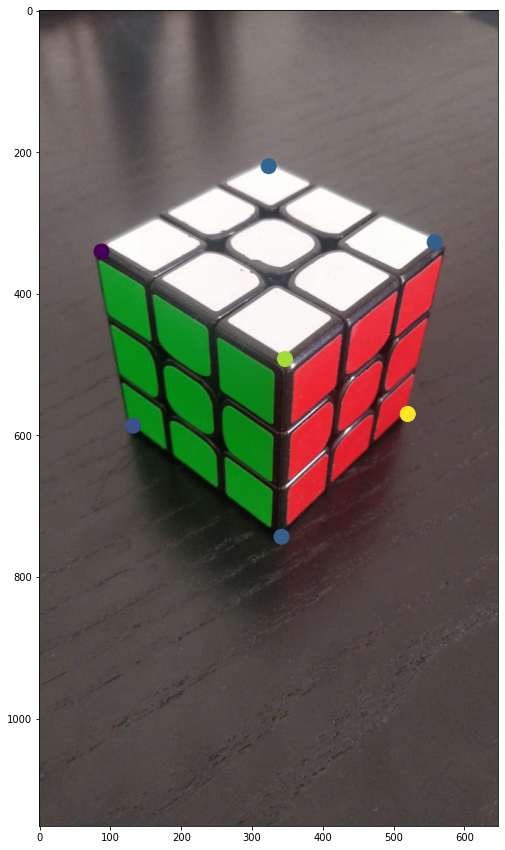

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10, 15))

img = mpimg.imread("q1/dlt1.jpeg")
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N)) ** 2

plt.scatter(image_points[:, 0], image_points[:, 1], c=colors, s=area)
plt.show()


After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
print(image_points)


[[131.94585878 586.18409736]
 [520.00812763 569.67080932]
 [341.66461684 743.06033371]
 [ 87.35998108 340.13610562]
 [323.5        219.58910295]
 [557.98869012 326.92547519]
 [346.61860325 492.05835555]]


In [4]:
# x represents the 2D image points
x = image_points

# X represents the 3D world points
X = []

X.append([0, 0, 0])
X.append([4, 4, 0])
X.append([4, 0, 0])
X.append([0, 0, 4])
X.append([0, 4, 4])
X.append([4, 4, 4])
X.append([4, 0, 4])

X = np.array(X, dtype=np.float64)


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


## Convert to Homogeneous Coordinates

In [5]:
x = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))


## Direct Linear Transform

In [6]:
def direct_linear_transform(image_points, world_points):
    x = image_points[:, 0]
    y = image_points[:, 1]

    X = world_points[:, 0]
    Y = world_points[:, 1]
    Z = world_points[:, 2]

    a_x = np.c_[
        -1 * X,
        -1 * Y,
        -1 * Z,
        -1 * np.ones(N),
        np.zeros(N),
        np.zeros(N),
        np.zeros(N),
        np.zeros(N),
        np.multiply(x, X),
        np.multiply(x, Y),
        np.multiply(x, Z),
        x,
    ]

    a_y = np.c_[
        np.zeros(N),
        np.zeros(N),
        np.zeros(N),
        np.zeros(N),
        -1 * X,
        -1 * Y,
        -1 * Z,
        -1 * np.ones(N),
        np.multiply(y, X),
        np.multiply(y, Y),
        np.multiply(y, Z),
        y,
    ]

    M = np.empty((2 * N, a_x.shape[1]))
    M[0::2, :] = a_x
    M[1::2, :] = a_y
    _, _, V_T = np.linalg.svd(M)
    V = V_T.T
    P = V[:, -1].reshape((3, 4))
    return P


In [7]:
P = direct_linear_transform(x, X)

### Theory

- Explain how DLT is implemented and show why it works (proof).
- When does DLT fail?

### Answer 1

DLT or Direct Linear Transform solves the problem of estimating the camera calibration matrix for an uncalibrated camera, i.e., it estimates both the camera extrinsic and intrinsic (without separating them, in its basic form).

Given a world point $\mathbf{X}$ and the corresponding image point $\mathbf{x}$, they satisfy.

$$
\begin{align}
\mathbf{x}_{3 \times 1} &= K_{3 \times 3}R_{3 \times 3}\left[I_{3 \times 3} \vert -\mathbf{t}_{3 \times 1} \right]\mathbf{X}_{4 \times 1} \\
\implies \mathbf{x}_{3 \times 1} &= P_{3 \times 4}\mathbf{X}_{4 \times 1}
\end{align}
$$

where $P$ are the camera projection matrix.

P has 11 unknowns: 3 rotations, 3 translations, $f_x$, $f_y$, $c$, $s$ and $m$ (or, alternatively, $P$ has 12 elements, and is homogenous, thereby leaving us with 11 parameters) that need to be estimated.

We know that each point gives us two equations (one for $x$ and one for $y$), and hence we need a minimum of 6 points.

**Forming the equations**

We divide by the third and fourth coordinate in $\mathbf{x}$ and $\mathbf{X}$ respectively to get

$$
\begin{bmatrix}
x \\
y \\
1 \\
\end{bmatrix} = P
\begin{bmatrix}
X \\
Y \\
Z \\
1 \\
\end{bmatrix}
$$

The equations look like
$$
\begin{align}
x &= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \\
y &= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
\end{align}
$$

Because these equations are not in a form that can be directly solved for $P$, we convert them to such a form by collecting all elements of $P$ in a vector and the other terms in a matrix.

$$
\mathbf{x_i} = 
\begin{bmatrix}
A^T \\
B^T \\
C^T \\
\end{bmatrix}
\mathbf{X}_i
$$
Where $A^T, B^T, C^T$ are the rows of $P$.

Hence, the individual coordinates become,
$$
x_i = \frac{A^T \mathbf{X_i}}{C^T \mathbf{X_i}} \\
y_i = \frac{B^T \mathbf{X_i}}{C^T \mathbf{X_i}}
$$

which gives us,

$$
x_i C^T \mathbf{X_i} - A^T \mathbf{X_i} = 0 \\
y_i C^T \mathbf{X_i} - B^T \mathbf{X_i} = 0
$$

which is a system of linear equations in $A$, $B$ and $C$ and can be written as:
$$
\begin{bmatrix}
-X_i & -Y_i & -Z_i & -1 &
0 & 0 & 0 & 0 &
x_i X_i & x_i Y_i & x_i Z_i & x_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0 \\
\begin{bmatrix}
0 & 0 & 0 & 0 &
-X_i & -Y_i & -Z_i & -1 &
y_i X_i & y_i Y_i & y_i Z_i & y_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0
$$

We combine this, for all the 6 (or more) points, into

$$
A_{2n \times 12}\mathbf{p}_{12 \times 1} = \mathbf{0}
$$

Now, because of noise, $A$ would most likely be full rank and have a non-existent null space (i.e., no $\mathbf{p}$ would satisfy this for all points in $A$). Hence. we minimise $||A\mathbf{p}||_2^2$, subject to $||\mathbf{p}|| = 1$ to avoid trivial solutions.

Thus, the DLT objective is
$$
p = argmin_{\mathbf{p}} \ \mathbf{p}^T A^T A\mathbf{p} \\
\text{such that} \ ||\mathbf{p}|| = 1
$$

The solution to this is the right singular vector corresponding to the smallest singular value of $A$, which is the eigenvector corresponding to the smallest eigenvalue of $A^T A$.

To minimize the effect of noise, more than 6 points are usually used, and techniques such as RANdom SAmple Consensus might be employed to nullify the effect of outliers, to which DLT is otherwise very susceptible.

Thus, DLT provides a mapping from the world points to the camera points for an uncalibrated camera.


### Answer 2

DLT will fail or $A\mathbf{p} = 0$ has no solution, if
- All points are located on a plane
- All points and projection center are located on a twisted cubic curve

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [8]:
# Get reprojected points
def get_points(P, X):
    x = P @ X.T
    x = np.true_divide(x[0:2, :], x[[-1], :])
    return x.T


# Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    diff = x[:, 0:2] - points
    error = np.linalg.norm(diff, axis=1)
    return np.mean(error)


In [9]:
print("Reprojection Error is:", get_err(x, X, P))


Reprojection Error is: 1.752075664943712


In [10]:
def plot_figure(points):
    n = len(points)
    fig = plt.figure(figsize=(10, 15))

    img = mpimg.imread("q1/dlt1.jpeg")
    imgplot = plt.imshow(img)

    colors = np.random.rand(n)
    area = (15 * np.ones(n)) ** 2

    plt.scatter(points[:, 0], points[:, 1], c=colors, s=area)
    plt.show()


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [11]:
def ret_RKT(P):
    H = P[:, 0:3]
    h = P[:, -1]

    H_inverse = np.linalg.pinv(H)

    X_0 = -H_inverse @ h

    R_T, K_inverse = np.linalg.qr(H_inverse)
    R = R_T.T

    K = np.linalg.pinv(K_inverse)

    T = -R @ X_0
    return R, K, T


R, K, T = ret_RKT(P)
T = T.reshape(T.shape[0], 1)


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [12]:
np.isclose(P, K @ np.hstack((R, T)))


array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [13]:
print(P)
print(K @ np.hstack((R, T)))


[[-6.91727033e-02 -9.95356745e-02  2.41700585e-02 -2.15856831e-01]
 [-2.82130523e-02  2.48067518e-02  1.26773566e-01 -9.59501880e-01]
 [ 4.73540921e-05 -6.74112929e-05  7.36365814e-05 -1.63249826e-03]]
[[-6.91727033e-02 -9.95356745e-02  2.41700585e-02 -2.15856831e-01]
 [-2.82130523e-02  2.48067518e-02  1.26773566e-01 -9.59501880e-01]
 [ 4.73540921e-05 -6.74112929e-05  7.36365814e-05 -1.63249826e-03]]


**Reproject the world points with P matrix you have obtained via DLT and visualize**

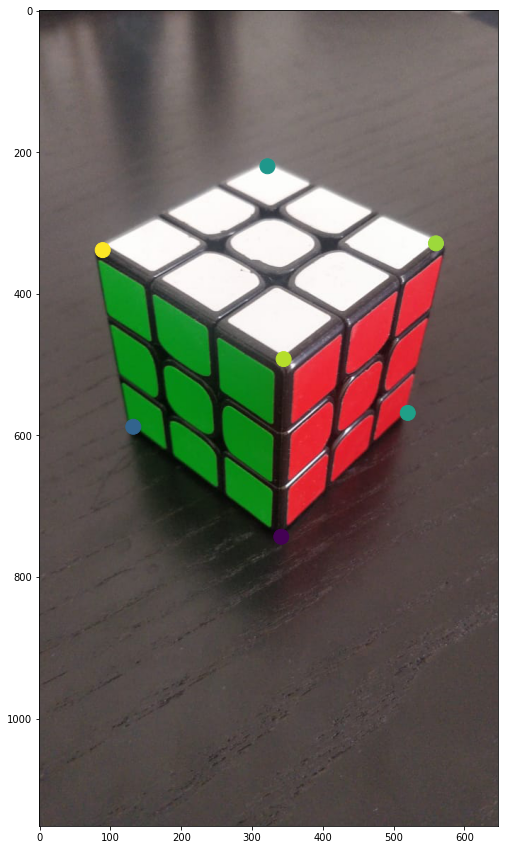

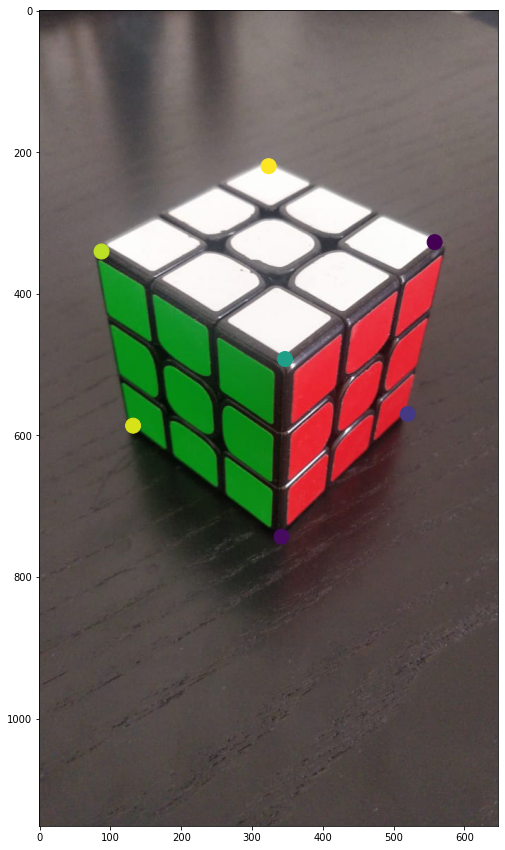

In [14]:
plot_figure(get_points(P, X))
plot_figure(x)

### Zhangs method

For this task, use the inbuilt OpenCV function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/Zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

- 3D points are called object points and 2D image points are called image points.

- To find pattern in chessboard, we can use the function, cv.findChessboardCorners(). We also need to pass what kind of pattern we are looking for, like 8x8 grid, 5x5 grid, etc. In this example, we use an 8x6 grid. (Normally, a chessboard has 8x8 squares and 7x7 internal corners). It returns the corner points and returns a value that will be True if the pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom)

- This function may not be able to find the required pattern in all the images. So, one good option is to write the code to start the camera and check each frame for the required pattern. Once the pattern is obtained, find the corners and store them in a list. Also, provide some intervals before reading the next frame to adjust our chessboard in a different direction. Continue this process until the required number of good patterns are obtained. Even in the example provided here, we are unsure how many images are good out of the 15 given. Thus, we must read all the images and take only the good ones.

- Once we find the corners, we can increase their accuracy using cv.cornerSubPix(). We can also draw the pattern using cv.drawChessboardCorners().

- Now that we have our object points and image points, we are ready to go for calibration. We can use the function cv.calibrateCamera(), which returns the camera matrix, distortion coefficients, rotation and translation vectors, etc.

In [15]:
import cv2 as cv

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 8, 3), np.float32)

objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.

objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

for index in range(5456, 5471):
    fname = f"q1/Zhangs/IMG_{index}.JPG"
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (8, 6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (8, 6), corners2, ret)
        cv.imshow("img", img)
        cv.waitKey(500)

cv.destroyAllWindows()


In [16]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [17]:
print("Root mean square (RMS) re-projection error:", ret)
print(mtx)

Root mean square (RMS) re-projection error: 2.288415145543703
[[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [119]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import svd


In [279]:
# Selecting corresponding points

%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

image_points = [
    [381, 402, 1],
    [452, 497, 1],
    [671, 538, 1],
    [501, 254, 1],
    [506, 381, 1],
    [474, 440, 1],
    [471, 537, 1],
    [498, 364, 1],
    [706, 319, 1],
    [635, 367, 1],
]
fig = plt.figure(figsize=(20, 30))

img = mpimg.imread("./q2/img1.jpg")


def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy, 1])


cid = fig.canvas.mpl_connect("button_press_event", onclick)

imgplot = plt.imshow(img)
plt.show()

image_points1 = [
    [390, 346, 1],
    [439, 412, 1],
    [651, 417, 1],
    [477, 194, 1],
    [482, 300, 1],
    [456, 359, 1],
    [454, 444, 1],
    [475, 287, 1],
    [686, 185, 1],
    [606, 253, 1],
]
fig1 = plt.figure(figsize=(20, 30))

img1 = mpimg.imread("./q2/img2.jpg")


def onclick1(event):
    ix, iy = event.xdata, event.ydata
    image_points1.append([ix, iy, 1])


cid = fig1.canvas.mpl_connect("button_press_event", onclick1)

imgplot = plt.imshow(img1)
plt.show()


In [390]:
image_points = np.array(image_points)
image_points1 = np.array(image_points1)

mean1 = np.mean(image_points, axis=0)
mean2 = np.mean(image_points1, axis=0)

std1 = np.std(image_points, axis=0)
std2 = np.std(image_points1, axis=0)

A = []
# Calculated Fundamental Matrix

for i in range(len(image_points)):
    [u, v] = np.true_divide((image_points[i][0:2] - mean1[0:2]), std1[0:2])
    [u_d, v_d] = np.true_divide((image_points1[i][0:2] - mean2[0:2]), std2[0:2])
    A.append([u * u_d, v_d * u, u, u_d * v, v * v_d, v, u_d, v_d, 1])

A = np.array(A, dtype=np.float64)
U, S, V_T = svd(A)
V = V_T.T

F = np.reshape(V[:, -1], (3, 3))
[FU, FD, FV_T] = svd(F)

D = np.diag([FD[0], FD[1], 0])

F = FU @ D @ FV_T

T1 = np.zeros((3, 3))
T1[0, 0] = 1 / std1[0]
T1[1, 1] = 1 / std1[1]
T1[0, 2] = -mean1[0]
T1[1, 2] = -mean1[1]
T1[2, 2] = 1

T2 = np.zeros((3, 3))
T2[0, 0] = 1 / std2[0]
T2[1, 1] = 1 / std2[1]
T2[0, 2] = -mean2[0]
T2[1, 2] = -mean2[1]
T2[2, 2] = 1

F = np.linalg.inv(T2) @ F @ T1

F /= F[2, 2]
print(F)

# FUNDAMENTAL MATRIX USING INBUILT FUNCTION

# ptsLeft = np.float64(image_points)
# ptsRight = np.float64(image_points1)
# F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, cv2.FM_LMEDS)
# print(F)

# PAST YEAR FUNDAMENTAL MATRIX

# F = [
#     [-1.29750186e-06, 8.07894025e-07, 1.84071967e-03],
#     [3.54098411e-06, 1.05620725e-06, -8.90168709e-03],
#     [-3.29878312e-03, 5.14822628e-03, 1.00000000e00],
# ]
# F = np.array(F)


[[-7.88900885e-01 -1.81310759e-01  4.81853633e+04]
 [-4.54595716e-01 -1.04265056e-01  2.77585036e+04]
 [-1.63791943e-05 -3.75271087e-06  1.00000000e+00]]


In [391]:
def epipolar_lines(img1_name, img2_name, points1, points2, F):
    img1 = plt.imread(img1_name)
    img2 = plt.imread(img2_name)
    x_max = img1.shape[1]

    for i in range(points1.shape[0]):
        line = F @ points1[i]
        x1 = 0
        y1 = int(-line[2] / line[1])
        x2 = img1.shape[1]
        y2 = int(-(line[2] + line[0] * img1.shape[1]) / line[1])
        color = [
            np.random.randint(1, 255),
            np.random.randint(1, 255),
            np.random.randint(1, 255),
        ]
        img2 = cv2.line(img2, (x1, y1), (x2, y2), color, 2)
        img2 = cv2.circle(img2, (int(points2[i][0]), int(points2[i][1])), 8, color, -1)
        img1 = cv2.circle(img1, (int(points1[i][0]), int(points1[i][1])), 8, color, -1)

    return img1, img2


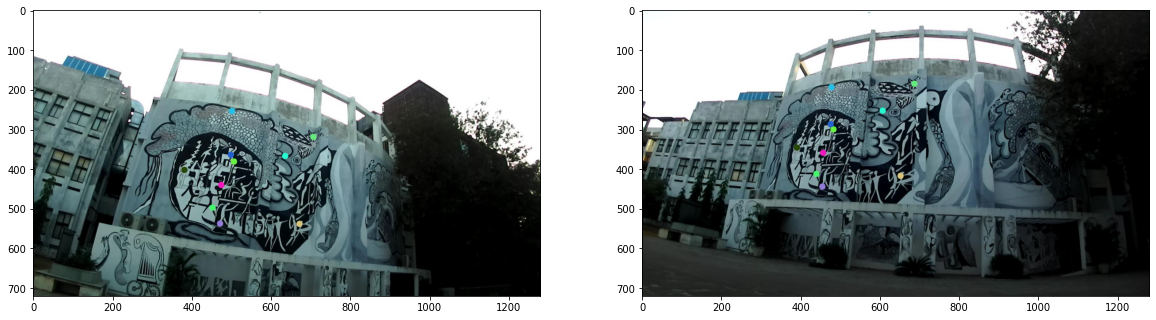

In [392]:
%matplotlib inline
H, W = 10, 10
ROWS, COLS = 1, 2
fig, ax = plt.subplots(ROWS, COLS, figsize=(H * COLS, W * ROWS))
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines(
    "q2/img1.jpg", "q2/img2.jpg", image_points, image_points1, F
)
ax[0].imshow(img1)
ax[1].imshow(img2)


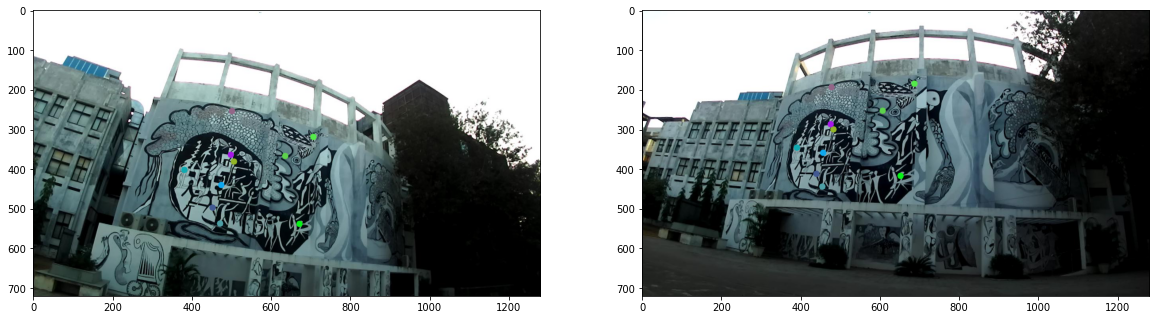

In [388]:
%matplotlib inline
fig, ax = plt.subplots(ROWS, COLS, figsize=(20, 10))
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines(
    "q2/img2.jpg", "q2/img1.jpg", image_points1, image_points, F.T
)
ax[0].imshow(img2)
ax[1].imshow(img1)


**Provide a clear explanation on your approach for both this task and the next**
# Explanation : 
The steps to compute the F matrix is:
1. We generate 8 corresponding pairs points in the given images.
2. Determine the $\hat(F)$ matrix by finding the svd corresponding to the smallest singular value of A
3. Make the F matrix singular by euquating its smallest singular value to 0, and recomputing the F using SVD.
quation of epipolar line corresponding to points of first image on second image is: $ F   X $  where $X$ represents points on first image and $F$ is Fundamental Matrix such that $x'^{T}Fx$ where $x'$ is the location of the point in the second image.                 

Here all coordinates are *Homogenous Coordinates* and Fundamental matrix is a $3*3$ matrix. So line equation we get after multiplying $F$ and $X$ is a $3*1$ matrix which can be represented as $ ax + by + c = 0 $ in *Euclidian Coordinates system*.                                    

By this way we got the equation of epipolar line and now to plot that line on image we used *cv2* line function which accepts two coordinates passing through the line and plots line on image. To find coordinates passing though the line:          
* $ x = 0 $ and calculate $y$ from line equation which comes out to be:  $ -c/b $
* calculate $y$ from line equation which comes out to be:  $ -(c + a*x)/b $

By this way we plot epipolar lines on images and to plot points on image we used *cv2* circle function which accepts coordinates of points which were already given in the dataset.

By the same way we plotted epipolar line on first image, its equation is: $ F^T   X' $  where $F^T$ is tranpose of $F$ (Fundamental Matrix) and $X'$ corresponds to points on second image.

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

In [27]:
def nullspace(A):
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(1e-13, 0 * s[0])
    nnz = (s >= tol).sum()
    return vh[nnz:].conj().T


In [28]:
# 1st image
epipole = nullspace(F.T)
print("Epipoles onf first image:", epipole[0] / epipole[2], epipole[1] / epipole[2])


Epipoles onf first image: [-5131.90963838] [-948.85463066]


In [29]:
# 2nd image
epipole = nullspace(F)
print("Epipoles onf second image:", epipole[0] / epipole[2], epipole[1] / epipole[2])


Epipoles onf second image: [2159.16628306] [1189.26810028]


# Explanation : 
We know that for every corresponding pixels x and x'.T , $xFx = 0$ and for a fixed x the corresponding x' will lie on the epipolar line by Fx = I'.
Since, all the epipolar line intersect at epipole, epipole always lie on the epipolar line and quation of line is $Fx = 0$,hence always satisfies $Fe = 0$. Hence , epipole would be right null space of F. Similarly, $e'$ would be left null space of F.

____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

In [30]:
%matplotlib tk
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.cm as cm
# import numpy as np


x = [[830], [300], [1]]
fig = plt.figure(figsize=(20, 30))

edges = np.array([1, 3, 5, 4, 1, 2, 6, 8, 7, 3, 5, 8, 6, 4, 6, 2, 7])
img = mpimg.imread("./q3/image.png")
Row3 = [np.sin(5 * np.pi / 180), 0, np.cos(5 * np.pi / 180)]
Row1 = [np.cos(5 * np.pi / 180), 0, -np.sin(5 * np.pi / 180)]
Row2 = [0, 1, 0]
K = np.mat(([7.2153e02, 0, 6.0955e02], [0, 7.2153e02, 1.7285e02], [0, 0, 1]))
Rot = np.mat((Row1, Row2, Row3))


def onclick2(event):
    ix, iy = event.xdata, event.ydata
    x.append([ix])
    x.append([iy])
    x.append([1])


#     image_points.append([ix, iy])


cid = fig.canvas.mpl_connect("button_press_event", onclick2)

imgplot = plt.imshow(img)
plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.image as mpimg
import matplotlib.cm as cm

# Given
# select the lowermost point as world origin
# print(x)


B = np.dot(np.linalg.inv(K), x)
print(B)
WorldPoint = 1.65 * B / B[1]
print(WorldPoint)

CarPoint = [[0], [0], [0]]
CarPoint2 = [[0], [0], [4.10]]
CarPoint3 = [[1.51], [0], [0]]
CarPoint4 = [[0], [-1.38], [0]]
CarPoint5 = [[1.51], [-1.38], [0]]
CarPoint6 = [[0], [-1.38], [4.10]]
CarPoint7 = [[1.51], [0], [4.10]]
CarPoint8 = [[1.51], [-1.38], [4.10]]


def Get_WorldPoints():
    # Calculating rotation
    WorldPoint2 = np.matmul(Rot, CarPoint2) + WorldPoint
    WorldPoint3 = np.matmul(Rot, CarPoint3) + WorldPoint
    WorldPoint4 = np.matmul(Rot, CarPoint4) + WorldPoint
    WorldPoint5 = np.matmul(Rot, CarPoint5) + WorldPoint
    WorldPoint6 = np.matmul(Rot, CarPoint6) + WorldPoint
    WorldPoint7 = np.matmul(Rot, CarPoint7) + WorldPoint
    WorldPoint8 = np.matmul(Rot, CarPoint8) + WorldPoint
    return np.array(
        (
            WorldPoint,
            WorldPoint2,
            WorldPoint3,
            WorldPoint4,
            WorldPoint5,
            WorldPoint6,
            WorldPoint7,
            WorldPoint8,
        )
    )


WorldPoints = Get_WorldPoints()


def get_line():
    global edges
    linemat = np.mat(((), (), ()))
    for i in range(edges.size):
        tmpmat = np.mat(K) @ np.mat(WorldPoints[edges[i] - 1])
        linemat = np.hstack((linemat, tmpmat / tmpmat[2]))
    return linemat


def Graph():

    picture = plt.imread("./q3/image.png")
    plt.imshow(picture)
    global edges

    for i in range(8):
        d2point = K @ WorldPoints[i]
        d2point = d2point / d2point[2]
        plt.plot(d2point[0], d2point[1], "bo")

    linematt = get_line()
    # print(linemat[0])

    plt.plot(linematt[0].T, linematt[1].T, linewidth="1", c="y")

    plt.show()


Graph()


[[0.3055313 ]
 [0.17622275]
 [1.        ]]
[[2.86073535]
 [1.65      ]
 [9.36314982]]
